# Scénario OpenClassrooms
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez **tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.**

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

# Missions
    - Analyse exploratoire
    - Variables : sélection, passage au log ?
    - Adresse comme simple prédicteur ?
    - Prédiction émission CO2 et consommation électrique totale des bâtiments NON DESTINÉS à HABITATION
    - Évaluer ENERGY STAR Score : intérêt, limite
    - ML , hyperparamètre 

In [1]:
#!conda install -c conda-forge dataprep

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [4]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


# Analyse exploratoire

In [37]:
for col in data.columns:
    print(col)
    print(data[col].nunique())
    
    

OSEBuildingID


TypeError: 'int' object is not iterable

In [6]:
data.ComplianceStatus.unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [7]:
data.ZipCode.unique()

array([98101., 98121., 98104., 98154., 98118., 98105., 98112., 98125.,
       98109., 98070., 98108., 98199., 98115., 98107., 98144., 98103.,
       98119., 98136., 98122., 98126., 98133., 98146., 98033., 98106.,
       98111., 98134., 98117., 98116., 98191., 98164., 98195., 98185.,
       98181., 98102., 98168., 98155., 98006., 98124., 98053., 98012.,
       98013., 98028., 98178., 98114., 98127., 98165., 98011., 98198.,
       98113., 98040., 98204., 98177., 98020., 98272., 98145.,    nan])

In [8]:
data.Outlier.unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [9]:
data.Outlier.value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [10]:
data.describe().round()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.0,3376.0,3360.0,3376.0,3376.0,3376.0,3376.0,3368.0,3376.0,3376.0,...,3371.0,3370.0,3367.0,3367.0,3367.0,3367.0,3367.0,0.0,3367.0,3367.0
mean,21209.0,2016.0,98117.0,4.0,48.0,-122.0,1969.0,1.0,5.0,94834.0,...,5403667.0,5276726.0,274596.0,1086639.0,3707612.0,13685.0,1368505.0,NaN,120.0,1.0
std,12224.0,0.0,19.0,2.0,0.0,0.0,33.0,2.0,5.0,218838.0,...,21610629.0,15938786.0,3912173.0,4352478.0,14850656.0,67098.0,6709781.0,NaN,539.0,2.0
min,1.0,2016.0,98006.0,1.0,47.0,-122.0,1900.0,0.0,0.0,11285.0,...,0.0,0.0,0.0,-33827.0,-115417.0,0.0,0.0,NaN,-1.0,-0.0
25%,19991.0,2016.0,98105.0,3.0,48.0,-122.0,1948.0,1.0,2.0,28487.0,...,925129.0,970182.0,0.0,187423.0,639487.0,0.0,0.0,NaN,9.0,0.0
50%,23112.0,2016.0,98115.0,4.0,48.0,-122.0,1975.0,1.0,4.0,44175.0,...,1803753.0,1904452.0,0.0,345130.0,1177583.0,3238.0,323754.0,NaN,34.0,1.0
75%,25994.0,2016.0,98122.0,7.0,48.0,-122.0,1997.0,1.0,5.0,90992.0,...,4222455.0,4381429.0,0.0,829318.0,2829632.0,11890.0,1189034.0,NaN,94.0,1.0
max,50226.0,2016.0,98272.0,7.0,48.0,-122.0,2015.0,111.0,99.0,9320156.0,...,873923712.0,471613856.0,134943456.0,192577488.0,657074389.0,2979090.0,297909000.0,NaN,16871.0,34.0


In [11]:
data.ZipCode.nunique()

55

<Figure size 720x720 with 0 Axes>

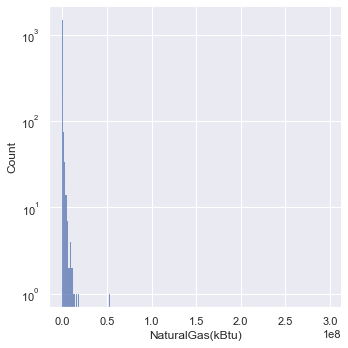

In [12]:
plt.figure(figsize=(10,10))
sns.displot(data=data,x='NaturalGas(kBtu)',log=True)

<Figure size 720x720 with 0 Axes>

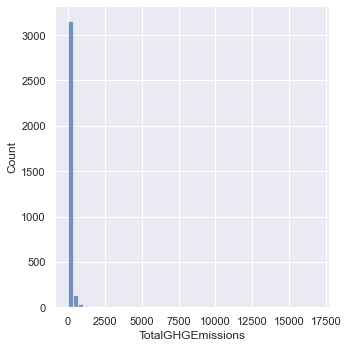

In [13]:
plt.figure(figsize=(10,10))
sns.displot(data=data,x='TotalGHGEmissions',bins=50)

In [14]:
np.log10(data['TotalGHGEmissions'])

C:\Users\arthk\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\arthk\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       2.397905
1       2.471086
2       3.319997
3       2.457019
4       2.703300
          ...   
3371    1.320977
3372    1.507451
3373    2.349355
3374    1.344589
3375    1.615634
Name: TotalGHGEmissions, Length: 3376, dtype: float64

## Valeurs manquantes

In [15]:
data.isna().mean().sort_values(ascending=False).head(15)

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
SourceEUI(kBtu/sf)                 0.002666
ListOfAllPropertyUseTypes          0.002666
TotalGHGEmissions                  0.002666
GHGEmissionsIntensity              0.002666
dtype: float64

## Variable Outlier ? 

In [16]:
data.loc[
    data['Outlier'].notnull()
]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,...,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,...,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,...,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,...,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,Seattle,WA,98121.0,0586400000,...,6.265616e+05,2137828.0,2700.760010,270076.0,False,NaN,Non-Compliant,Low outlier,29.25,0.17
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,Belmont Lofts,231 Belmont Ave E,Seattle,WA,98102.0,0704600000,...,7.502090e+04,255971.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,1.78,0.06
839,19967,2016,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.0,0811000005,...,7.228240e+04,246628.0,1848.439575,184844.0,True,NaN,Error - Correct Default Data,Low outlier,11.54,0.32
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,City Lights on Harbor,2349 Harbor Ave. SW,Seattle,WA,98126.0,1595200000,...,2.058855e+05,702481.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,4.90,0.07
1045,20617,2016,NonResidential,Retail Store,Seattle Habitat Store,21 S Nevada St,Seattle,WA,98134.0,1824049074,...,1.436250e+04,49005.0,964.640015,96464.0,True,NaN,Error - Correct Default Data,Low outlier,5.46,0.14
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,...,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00


Text(0.5, 1.0, 'Emissions par types de bâtiments')

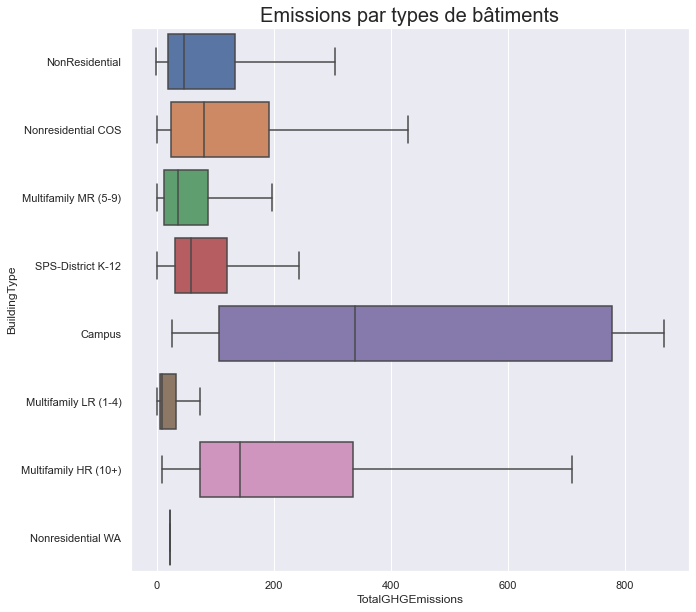

In [17]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='BuildingType',
    x='TotalGHGEmissions',
    showfliers = False
    ).set_title("Emissions par types de bâtiments",
               fontdict={'size': 20}
               )

Text(0.5, 1.0, "Emissions par types d'activités")

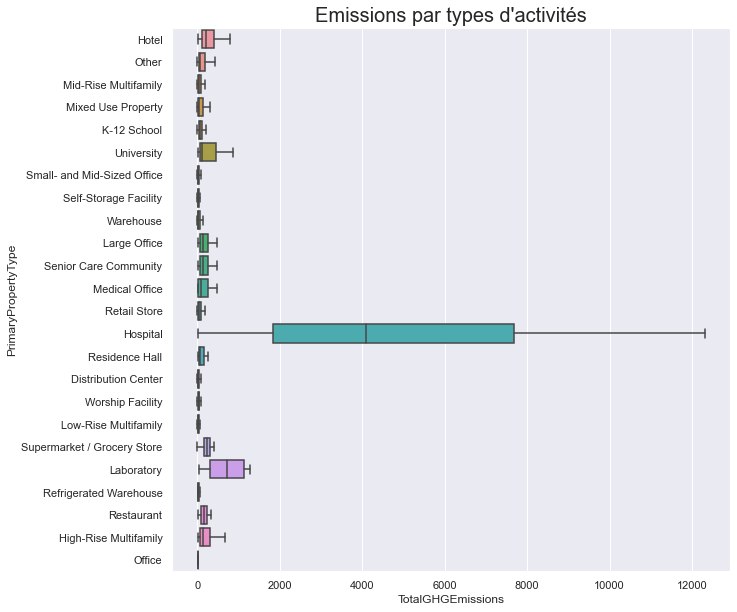

In [18]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='PrimaryPropertyType',
    x='TotalGHGEmissions',
    showfliers = False

).set_title(
    "Emissions par types d'activités",
    fontdict={'size': 20}
)

Text(0.5, 1.0, "Emissions par types d'activités sans les Hopitaux")

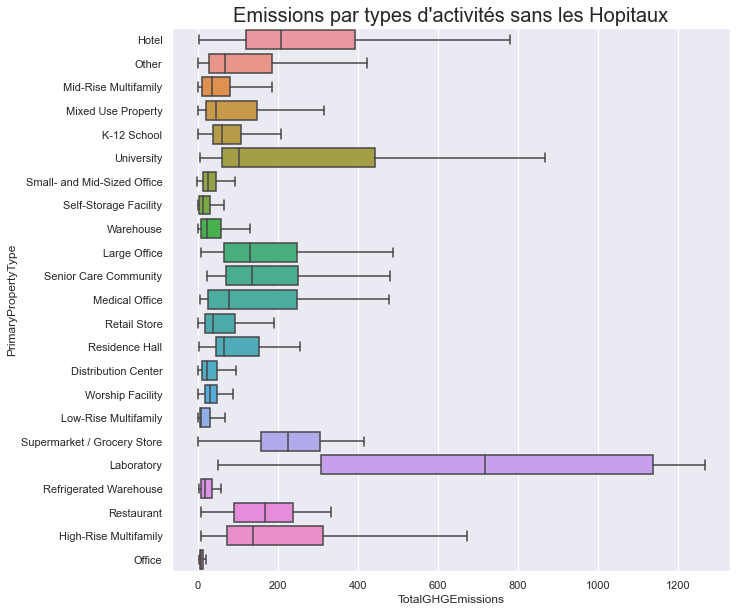

In [19]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data.loc[
        data['PrimaryPropertyType'] != 'Hospital'
    ], 
    y='PrimaryPropertyType',
    x='TotalGHGEmissions',
    showfliers = False

).set_title(
    "Emissions par types d'activités sans les Hopitaux",
    fontdict={'size': 20}
)

Text(0.5, 1.0, 'Emissions par quartiers')

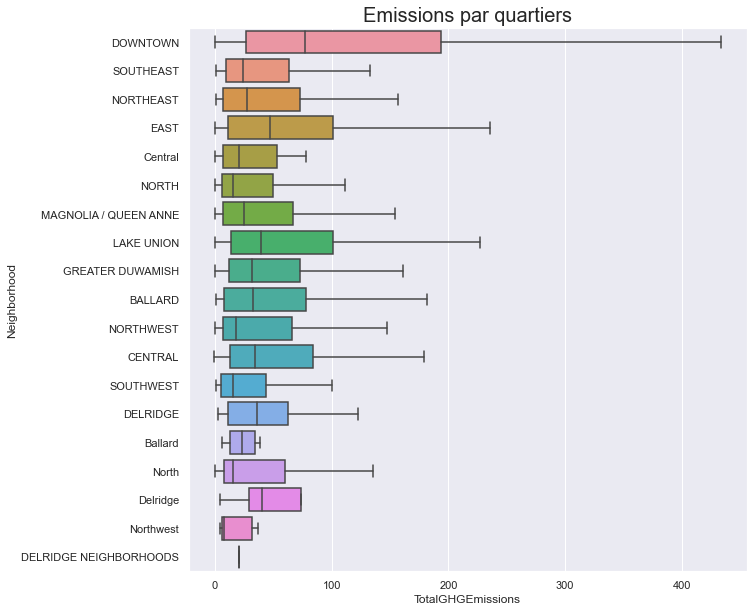

In [20]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='Neighborhood',
    x='TotalGHGEmissions',
    showfliers = False
).set_title("Emissions par quartiers",
               fontdict={'size': 20}
               )

Text(0.5, 1.0, 'Emissions m2 par années de construction')

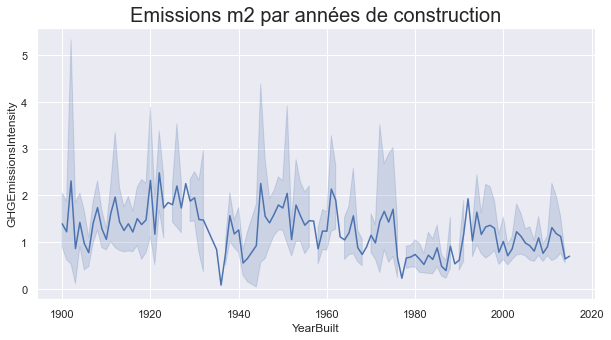

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data, 
    y='GHGEmissionsIntensity',
    x='YearBuilt').set_title("Emissions m2 par années de construction",
               fontdict={'size': 20}
               )

> Émissions liées à l'activité : construction, secteur industriel. Période de la Seconde Guerre Mondiale et après guerre pic d'activité.

In [22]:
data[['TotalGHGEmissions','GHGEmissionsIntensity']].describe()

,TotalGHGEmissions,GHGEmissionsIntensity
count,3367.000000,3367.000000
mean,119.723971,1.175916
std,538.832227,1.821452
min,-0.800000,-0.020000
25%,9.495000,0.210000
50%,33.920000,0.610000
75%,93.940000,1.370000
max,16870.980000,34.090000


In [23]:
data[['TotalGHGEmissions','GHGEmissionsIntensity']].corr()

,TotalGHGEmissions,GHGEmissionsIntensity
TotalGHGEmissions,1.000000,0.470212
GHGEmissionsIntensity,0.470212,1.000000


In [24]:
data[['TotalGHGEmissions','NumberofBuildings']].corr()

,TotalGHGEmissions,NumberofBuildings
TotalGHGEmissions,1.000000,0.405261
NumberofBuildings,0.405261,1.000000


<AxesSubplot:>

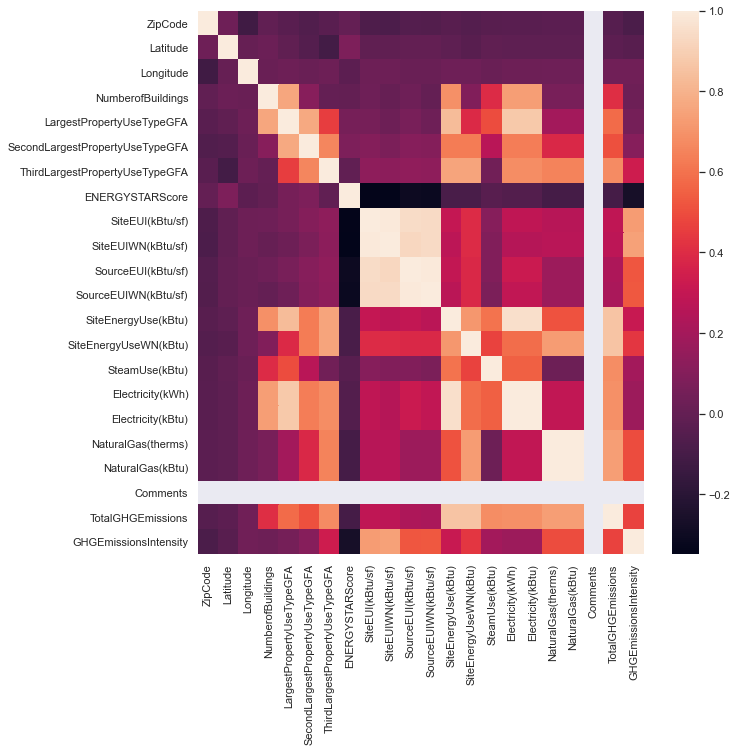

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(
    data.select_dtypes(include=['float64']).corr()
)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<AxesSubplot:ylabel='Frequency'>

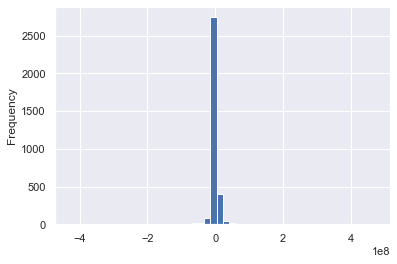

In [27]:
data['SiteEnergyUseWN(kBtu)'].diff().plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

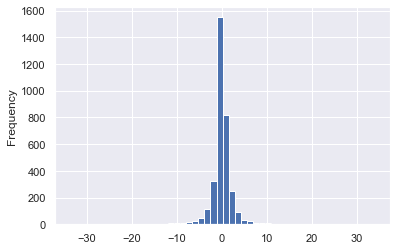

In [28]:
data.GHGEmissionsIntensity.diff().plot.hist(bins=50)

In [29]:
23*0.7

16.099999999999998

In [30]:
data.ListOfAllPropertyUseTypes.unique()

array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility',
       'Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office',
       'Non-Refrigerated Warehouse, Office, Refrigerated Warehouse',
       'Non-Refrigerated Warehouse, Office', 'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, 

In [31]:
data.GHGEmissionsIntensity.nunique()               

511

In [32]:
data.ComplianceStatus.unique() 

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

#enlever non compliant 

# Nettoyage 
    Suppression des Outliers
    Première selection des variables

# Sélection des valeurs non résidentielles 

In [41]:
data['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [56]:
Non_Residential_select = ['NonResidential','Nonresidential COS','SPS-District K-12','Nonresidential WA','Campus']

In [57]:
df = data.loc[data['BuildingType'].isin(Non_Residential_select)]

In [68]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [59]:
df.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

Doit-on conserver : 
- les maisons de retraite ==> Senior Care community , 
- Mixed use Property, 
- residence universitaire : Residence Hall, 
- Low-Rise Multifamily ?

#### On conserve uniquement les logements Mixed use Property

In [66]:
drop_PrimaryPropertyType = ['Low-Rise Multifamily','Residence Hall','Senior Care Community']

df = df.loc[~df['PrimaryPropertyType'].isin(drop_PrimaryPropertyType)]

df.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Medical Office', 'Retail Store', 'Hospital',
       'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Office'], dtype=object)

In [76]:
df.loc[ 
    (df['PrimaryPropertyType']=='Mixed Use Property')
].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
18,24,2016,NonResidential,Mixed Use Property,The Rainier Club,820 4th Ave.,Seattle,WA,98104.0,0942000510,...,1.103397e+06,3764791.0,2.065091e+04,2065091.0,False,NaN,Compliant,NaN,273.02,4.75
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,...,4.410208e+07,150476283.0,2.979090e+06,297909000.0,False,NaN,Compliant,NaN,16870.98,34.09
47,60,2016,NonResidential,Mixed Use Property,Mann Building,1401 3rd Avenue,Seattle,WA,98101.0,1975700525,...,1.357696e+06,4632459.0,1.039374e+05,10393737.0,False,NaN,Compliant,NaN,584.31,11.12
65,96,2016,NonResidential,Mixed Use Property,Central Seattle,921 Terry Ave.,Seattle,WA,98104.0,1979200290,...,2.973421e+06,10145313.0,0.000000e+00,0.0,False,NaN,Compliant,NaN,481.97,4.83
164,264,2016,NonResidential,Mixed Use Property,TriBeCa,516 1st Ave W,Seattle,WA,98119.0,8681450000,...,2.971734e+06,10139555.0,4.183540e+03,418354.0,False,NaN,Compliant,NaN,92.91,0.84


On retouve dans Mixed Use Property des pompiers , sécurité, ou logement mixed de type club sportif, institut

 ### Données aberrantes / non conforme 

In [83]:
df.Outlier.value_counts()

Low outlier     14
High outlier     2
Name: Outlier, dtype: int64

In [78]:
df['ComplianceStatus'].value_counts()

Compliant                       1505
Error - Correct Default Data      88
Non-Compliant                     17
Missing Data                      14
Name: ComplianceStatus, dtype: int64

In [79]:
df.DefaultData.value_counts()

False    1536
True       88
Name: DefaultData, dtype: int64

In [95]:
df.loc[
        (df['Outlier'].notnull()) 
].TotalGHGEmissions.describe()

count     16.000000
mean      38.854375
std       98.084673
min        0.120000
25%        0.650000
50%        2.865000
75%        9.327500
max      362.660000
Name: TotalGHGEmissions, dtype: float64

In [96]:
df.loc[
        (df['Outlier'].isnull()) &
        (df['ComplianceStatus']=='Compliant')
].TotalGHGEmissions.describe()

count     1505.000000
mean       192.750884
std        788.344773
min         -0.800000
25%         20.120000
50%         49.250000
75%        142.390000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

#### On supprimer les Outliers

In [97]:
df = df.loc[
            (df['Outlier'].isnull()) &
            (df['ComplianceStatus']=='Compliant')
]

In [102]:
df.loc[
        df['TotalGHGEmissions'] < 0
]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,-33826.80078,-115417.0,0.0,0.0,False,NaN,Compliant,NaN,-0.8,-0.02


In [113]:
df.loc[
        (df['TotalGHGEmissions'] < 0) 
]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,-33826.80078,-115417.0,0.0,0.0,False,NaN,Compliant,NaN,-0.8,-0.02


In [114]:
df = df.loc[
        df['TotalGHGEmissions'] > 0
]

# Sélection des variables
    Variables non informatives 

In [134]:
df = df.drop(['City', # Valeur unique 
         'State', # valeur unique 
         'DataYear', # valeur unique 
         'ZipCode', # variable non informative
         'TaxParcelIdentificationNumber', # variable non informative
         'Comments', # 100 % NA
         'Outlier', # valeur unique car cleané 
         'ComplianceStatus', # valeur unique car cleané 
         'DefaultData', # valeur unique car cleané 
         'YearsENERGYSTARCertified', # 94 % missing data
        ], 
        axis = 1)

KeyError: "['City' 'State' 'DataYear' 'ZipCode' 'TaxParcelIdentificationNumber'\n 'Comments' 'Outlier' 'ComplianceStatus' 'DefaultData'\n 'YearsENERGYSTARCertified'] not found in axis"

In [135]:
df.isna().mean().sort_values(ascending=False).head(10)

ThirdLargestPropertyUseType        0.773786
ThirdLargestPropertyUseTypeGFA     0.773786
SecondLargestPropertyUseType       0.452428
SecondLargestPropertyUseTypeGFA    0.452428
ENERGYSTARScore                    0.363273
LargestPropertyUseTypeGFA          0.002661
LargestPropertyUseType             0.002661
SiteEUIWN(kBtu/sf)                 0.000665
SiteEnergyUseWN(kBtu)              0.000665
Neighborhood                       0.000000
dtype: float64

In [132]:
df[df.columns[df.columns.str.contains('LargestPropertyUseType')]]

,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
0,Hotel,88434.0,NaN,NaN,NaN,NaN
1,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0
2,Hotel,756493.0,NaN,NaN,NaN,NaN
3,Hotel,61320.0,NaN,NaN,NaN,NaN
4,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0
...,...,...,...,...,...,...
3370,Other - Recreation,18261.0,NaN,NaN,NaN,NaN
3372,Other - Recreation,16000.0,NaN,NaN,NaN,NaN
3373,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0
3374,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0


In [172]:
pd.concat(
[df['LargestPropertyUseType'],
df['SecondLargestPropertyUseType'],
df['ThirdLargestPropertyUseType']]
)

0                    Hotel
1                    Hotel
2                    Hotel
3                    Hotel
4                    Hotel
               ...        
3370                   NaN
3372                   NaN
3373         Swimming Pool
3374    Pre-school/Daycare
3375    Pre-school/Daycare
Length: 4509, dtype: object

In [177]:
pt = pd.DataFrame({
    'id' : pd.concat([df.OSEBuildingID, df.OSEBuildingID, df.OSEBuildingID]),
    'type' : pd.concat([df[col] for col in ["LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]),
    'sf' : pd.concat([df[col] for col in ["LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]]),
    'total' : pd.concat([df.PropertyGFATotal, df.PropertyGFATotal, df.PropertyGFATotal])
})
pt['sf'] = pt['sf']/pt['total']

In [179]:
pt.pivot_table(index='id',columns='type',values='sf').fillna(0)

type,Adult Education,Automobile Dealership,Bank Branch,Bar/Nightclub,College/University,Convenience Store without Gas Station,Courthouse,Data Center,Distribution Center,Enclosed Mall,...,Retail Store,Self-Storage Facility,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Swimming Pool,Urgent Care/Clinic/Other Outpatient,Vocational School,Wholesale Club/Supercenter,Worship Facility
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
df

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,7,DOWNTOWN,47.61220,-122.33799,1927,...,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,7,DOWNTOWN,47.61317,-122.33393,1996,...,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,7,DOWNTOWN,47.61393,-122.33810,1969,...,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,7,DOWNTOWN,47.61412,-122.33664,1926,...,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,7,DOWNTOWN,47.61375,-122.34047,1980,...,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,Nonresidential COS,Other,High Point Community Center,6920 34th Ave SW,1,DELRIDGE NEIGHBORHOODS,47.54067,-122.37441,1982,...,136.600006,9.320821e+05,1.025432e+06,0.00,1.853347e+05,6.323620e+05,2997.199951,2.997200e+05,20.33,1.11
3372,50223,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,2,DOWNTOWN,47.59625,-122.32283,2004,...,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01
3373,50224,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,...,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,1,GREATER DUWAMISH,47.52832,-122.32431,1989,...,110.800003,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,1.57


### Faudrait-il decouper les variables PropertyUse en 3 ?
    éviter les NA
    Avoir plus de lignes
    3 proprité pour une même adresse

# A faire 

    Les deux variables que l'on cherche à prédire : totalGHGemission et SiteEnergyUseWN(kBtu).

- Dans un premier temps, on ne garde que les batîments non destinés à l'habitation. ==> OK !
- On garde aussi les données "fiables" : variables "outlier" et "compliance". == > OK !

- Ensuite tu peux commencer le feature engineering, dont le plus gros sera l'utilisation des batîments et leurs surfaces. 

- On va aussi calculer la part d'electricité, gaz et steam pour chaque batîments, car les relevés sont trop couteux et n'existeront plus à l'avenir.

Nous avons transformé ensemble les variables catégorielles (utilisations des batîments) en variable numérique (part de surface par type d'utilisation).

Ce qu'il reste à faire : 

- regrouper certaines catégories pour avoir moins de colonnes à la fin

- regarder la distribution des Y, puis transformer en log si pas normale

- Faire un KFold avec 5 splits, et en fixant random_state

- faire des modèles : linearRegression randomforest, xgboost, lightgbm, pourquoi pas un autre ? réseau de neurone ou SVM

On fera la recherche des hyperparamètres la prochaine fois !

# Feature Engineering

In [141]:
df.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [144]:
df.select_dtypes(include=['float64'])

,Latitude,Longitude,NumberofBuildings,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,47.61220,-122.33799,1.0,88434.0,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83
1,47.61317,-122.33393,1.0,83880.0,15064.0,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86
2,47.61393,-122.33810,1.0,756493.0,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19
3,47.61412,-122.33664,1.0,61320.0,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67
4,47.61375,-122.34047,1.0,123445.0,68009.0,0.0,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,47.54067,-122.37441,1.0,18261.0,NaN,NaN,NaN,51.000000,56.200001,126.000000,136.600006,9.320821e+05,1.025432e+06,0.00,1.853347e+05,6.323620e+05,2997.199951,2.997200e+05,20.33,1.11
3372,47.59625,-122.32283,1.0,16000.0,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01
3373,47.63644,-122.35784,1.0,7583.0,5574.0,0.0,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,16.99
3374,47.52832,-122.32431,1.0,6601.0,6501.0,484.0,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,1.57


## NumberofBuildings

In [147]:
df['NumberofBuildings'].describe()

count    1503.000000
mean        1.184963
std         3.084105
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       111.000000
Name: NumberofBuildings, dtype: float64

<AxesSubplot:>

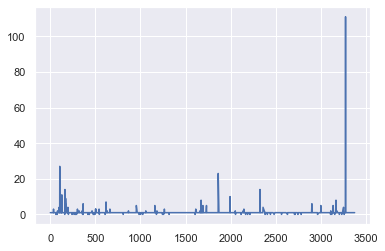

In [150]:
df['NumberofBuildings'].plot()

In [154]:
df.loc[
        df['NumberofBuildings'] > 5
]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,...,SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
105,172,Campus,University,SSCC MAIN CAMPUS,6000 16th Ave SW,1,DELRIDGE,47.547000,-122.353070,1970,...,202.600006,3.830174e+07,4.115173e+07,0.0,7.419278e+06,25314575.0,1.298717e+05,12987166.0,866.23,1.96
124,198,NonResidential,Hospital,Seattle Children's Hospital Main Campus,4800 Sand Point Way NE,4,NORTHEAST,47.662310,-122.281460,1953,...,576.599976,2.538325e+08,2.577642e+08,0.0,3.389250e+07,115641210.0,1.381912e+06,138191238.0,8145.52,9.27
128,211,Campus,University,NSCC MAIN CAMPUS,9600 COLLEGE WAY N,5,NORTHWEST,47.699360,-122.334010,1970,...,167.000000,3.589148e+07,3.741080e+07,0.0,9.803878e+06,33450832.0,2.440648e+04,2440648.0,362.82,0.52
162,261,Campus,Large Office,South Park,1420 S Trenton,1,GREATER DUWAMISH,47.524290,-122.312340,1980,...,453.299988,5.346668e+07,5.413607e+07,0.0,1.328294e+07,45321378.0,8.145300e+04,8145300.0,748.55,2.24
167,268,NonResidential,Hospital,Swedish Cherry Hill,500 17th Ave,3,CENTRAL,47.607050,-122.309660,1990,...,459.200012,1.434230e+08,1.472991e+08,0.0,1.722008e+07,58754927.0,8.466809e+05,84668094.0,4906.33,8.21
170,276,NonResidential,Hospital,Harborview Medical Center,325 9th Ave.,3,EAST,47.603990,-122.323770,2000,...,502.799988,2.930908e+08,2.966717e+08,122575032.0,4.943834e+07,168683602.0,1.832129e+04,1832129.0,10734.57,9.26
364,516,NonResidential,Other,Aurora Shopping Center,13201 Aurora Avenue North,5,NORTHWEST,47.725460,-122.346590,1964,...,193.000000,9.814820e+06,1.007999e+07,0.0,1.872845e+06,6390148.0,3.424670e+04,3424670.0,226.43,2.02
618,828,NonResidential,Hospital,Swedish First Hill,747 Broadway,3,EAST,47.608951,-122.322402,1994,...,378.399994,2.916144e+08,2.959299e+08,134943456.0,4.084256e+07,139354828.0,1.731612e+05,17316120.0,12307.16,6.97
1672,23071,NonResidential,Hospital,Main Hospital - All Wings,Facilities Management MS: B-120,5,NORTHWEST,47.714250,-122.336890,1966,...,402.100006,9.896078e+07,1.003283e+08,0.0,1.256277e+07,42864158.0,5.609661e+05,56096612.0,3278.11,7.89
1862,23622,Campus,Other,FT C15 Fishermen's Center,1900 West Nickerson Street,7,MAGNOLIA / QUEEN ANNE,47.655610,-122.380630,1955,...,374.500000,3.401298e+07,3.603458e+07,0.0,7.882361e+06,26894616.0,7.118362e+04,7118362.0,565.55,2.17


In [162]:
df[['NumberofBuildings','GHGEmissionsIntensity']].corr()

,NumberofBuildings,GHGEmissionsIntensity
NumberofBuildings,1.00000,0.02607
GHGEmissionsIntensity,0.02607,1.00000


<AxesSubplot:>

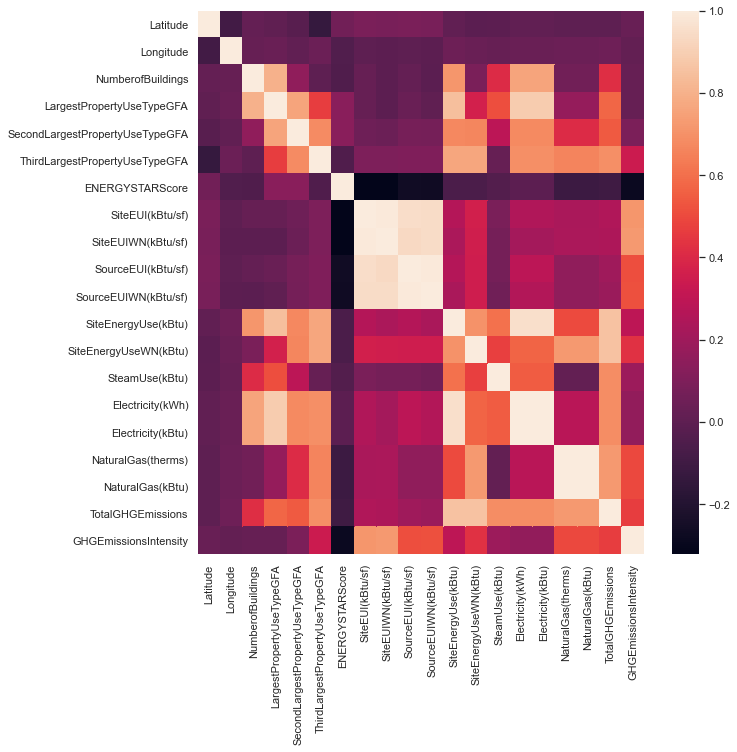

In [161]:
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include=['float64']).corr())